# Statistical issues in naive calibration analyses

The statistical problem of calibrating a sample with observable pairs $\hat a$ and $\hat b$ is challenging if random stochastic fluctuations affect both numbers of the pair. Even if the unknown true values $(a, b)$ have a perfectly linear relationship and if the stochastic fluctuations around $(a, b)$ are symmetric, a binned profile of the $\hat b$ values as a function of the $\hat a$ values may indicate a departure from a linear dependence. This happens if the stochastic fluctuations of $\hat a$ around $a$ are not negligible compared to the bin size.

We demonstrate this in the following with toy simulation. We assume fluctuations that are relative to the true values and that the true pairs $(a,b)$ are not uniformly distributed, but follow an exponential distribution. This is commonly the case in particle physics.

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.194 (χ²/ndof = 0.5)      │              Nfcn = 31               │
│ EDM = 1.42e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

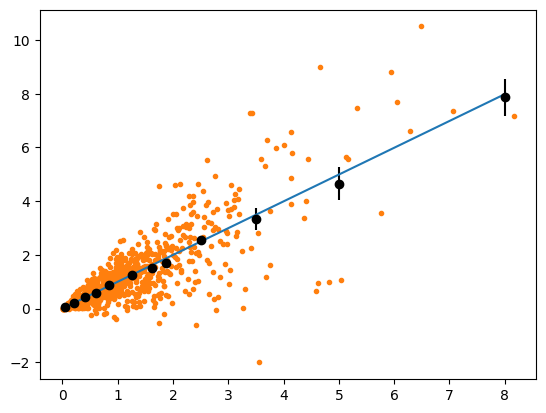

In [41]:
import numpy as np
from matplotlib import pyplot as plt
import boost_histogram as bh
from iminuit import Minuit
from iminuit.cost import LeastSquares

rng = np.random.default_rng(1)

x_true = rng.exponential(1, size=1000)
# x_true = rng.uniform(0, 10, size=1000)
y_true = x_true.copy()

def sigma_x(x_true):
    return x_true * 0.1

def sigma_y(y_true):
    return y_true * 0.5

x0 = rng.normal(x_true, sigma_x(x_true))
y0 = rng.normal(y_true, sigma_y(y_true))

x = x0
y = y0

h = bh.Histogram(bh.axis.Variable([0, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 1.75, 2, 3, 4, 6, 10]), storage=bh.storage.Mean())
h.fill(x, sample=y)

def line(x, a, b):
    return a + x * b

m = Minuit(LeastSquares(h.axes[0].centers, h.values(), h.variances() ** 0.5, line), 0, 0)
m.migrad()

plt.scatter(x, y, marker=".", color="C1")
m.visualize()
print(m)

We find excellent linearity, the fitted line is compatible with zero offset and a slope of one.

Now we swap the roles of `x` and `y` and perform the exact same analysis again. An analysis based on a profile is not treating `x` and `y` symmetrically, therefore it is possible that we get another answer, although fundamentally it does not matter whether we study pairs `(x, y)` or `(y, x)`.

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8884 (χ²/ndof = 888.4)     │              Nfcn = 35               │
│ EDM = 1.01e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

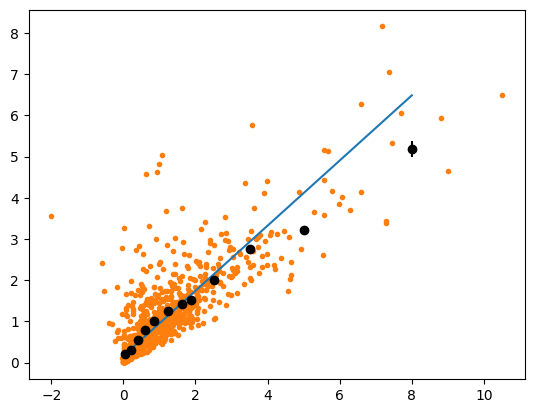

In [42]:
x = y0
y = x0

h = bh.Histogram(bh.axis.Variable([0, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 1.75, 2, 3, 4, 6, 10]), storage=bh.storage.Mean())
h.fill(x, sample=y)

m = Minuit(LeastSquares(h.axes[0].centers, h.values(), h.variances(), line), 0, 0)
m.migrad()

plt.scatter(x, y, marker=".", color="C1")
m.visualize()
print(m)

Both eye inspection and the fit indicate that the data is not linear, although it actually is. This surprising result is obtained even though the fluctuations in both `x` and `y` are symmetric around the true value. It originates from bin migration effects, which are not taken into account in this simple study.

It is possible to avoid the bias with a more sophisticated analysis that properly treats this problem with the maximum likelihood method. Such an analysis was developed to calibrate the Pierre Auger Observatory, which can be transferred to other calibration problems.

[H. Dembinski, B. Kégl, I.C. Maris, M. Roth, D. Veberič, Astropart.Phys. 73 (2016) 44-51](https://inspirehep.net/literature/1357170)

If the proper likelihood analysis of the problem cannot be performed, one should always bin in the variable which depicts smaller fluctuations and try to make the bins large compared to these fluctuations to minimize bin migration. However, this can also be counter-productive as making bins larger increases another bias from mixing samples that have locally different expectation values and densities.

Even then, however, it is not guaranteed that biases are absent. This needs to confirmed with toy simulations.

If the extra effort needed to patch up a naive analysis is included, the amount of work is as great or larger to using the proper likelihood analysis described in the paper, which makes the likelihood analysis the economic choice.

## Partial solution: modified least-squares method

A partial solution that may produce good results on some data is the modified least-squares method. It requires point estimates for the uncertainties of the x and y values. The standard least-squares method assumes that the x-values are known and only the y-values carry Gaussian uncertainties. Gaussian uncertainties on x-values can be approximately taken into account via error-propagation inside the cost function, using the current estimate of the fitting function.

This method works well, if the point estimates of the errors are fairly accurate and if the fitted function is not far from linear on the scale of the x-errors.

In our toy example, we get good results if we use the true uncertainties per point, but the results are poor if we try to estimate the uncertainties from the observed values.

In [46]:
# with small error on x
sx_true = sigma_x(x_true)
sy_true = sigma_y(y_true)

x, y = x0, y0
sx, sy = sx_true, sy_true

def chi2(a, b):
    ym = line(x, a, b)
    dy_dx = b
    var = (dy_dx * sx) ** 2 + sy ** 2
    res = (y - ym) ** 2 / var
    return np.sum(res)

chi2.ndata = len(x)


def visualize(args):
    a, b = args
    ym = line(x, a, b)
    plt.plot(x, ym, zorder=3)
    plt.errorbar(x, y, np.abs(sigma_y(y)), np.abs(sigma_x(x)), fmt=".", alpha=0.5)

chi2.visualize = visualize

m = Minuit(chi2, 0, 1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 953.6 (χ²/ndof = 1.0)      │              Nfcn = 31               │
│ EDM = 1.57e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -1.2e-3  │  0.8e-3   │            │            │         │         │       │
│ 1 │ b    │   1.013   │   0.017   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │ 6.42e-07  -3.5e-6 │
│ b │  -3.5e-6 0.000277 │
└───┴───────────────────┘

In [47]:
# with large error on x
sx_true = sigma_x(x_true)
sy_true = sigma_y(y_true)

y, x = x0, y0
sy, sx = sx_true, sy_true

m = Minuit(chi2, 0, 1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 953.6 (χ²/ndof = 1.0)      │              Nfcn = 38               │
│ EDM = 1.13e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  1.2e-3   │  0.8e-3   │            │            │         │         │       │
│ 1 │ b    │   0.987   │   0.016   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │ 6.17e-07  -3.0e-6 │
│ b │  -3.0e-6 0.000263 │
└───┴───────────────────┘

This fit is already slightly biased due to the points at negative x-values.

The fit gets badly biased if we don't know the true uncertainties per point and have to estimate them based on the observed x- and y-values. For the y-values, we can do a bit better by using the predicted y-value from the model to compute the uncertainty estimate, but this trick does not work for the x-values.

In [51]:
# with small error on x, but errors estimated from observed x,y
x, y = x0, y0
sx = np.abs(sigma_x(x))

def chi2(a, b):
    ym = line(x, a, b)
    dy_dx = b
    # estimate y-error using predicted y-values
    sy = sigma_y(ym)
    var = (dy_dx * sx) ** 2 + sy ** 2
    res = (y - ym) ** 2 / var
    return np.sum(res)

chi2.ndata = len(x)
chi2.visualize = visualize

m = Minuit(chi2, 0, 1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 753.9 (χ²/ndof = 0.8)      │              Nfcn = 71               │
│ EDM = 1.76e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -1.7e-3  │  0.8e-3   │            │            │         │         │       │
│ 1 │ b    │   1.280   │   0.023   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │ 6.36e-07  -4.6e-6 │
│ b │  -4.6e-6 0.000554 │
└───┴───────────────────┘

We are not recovering the expected (0, 1) parameters.

## General solution: maximum-likelihood method with hierarchical statistical model

The correct solution from first principles is to write down a statistical model of the calibration process. This model is hierarchical. The first step is to draw a sample of unknown true values $x, y$ from the underlying frequency distribution (here an exponential). This needs to be folded with normal distributions to model the observed distribution.

Following section A of [H. Dembinski, B. Kégl, I.C. Maris, M. Roth, D. Veberič, Astropart.Phys. 73 (2016) 44-51](https://inspirehep.net/literature/1357170), we get for this toy example

$$
f(x, y; \vec p) = \int \text{d}x_\text{true} \, g(x; x_\text{true}, \sigma_x) \, g(y; f(x_\text{true}, \vec{p}), \sigma_y) \, h(x_\text{true})
$$

where $g$ is a normal distribution and $h$ is an exponential. This solution treats x- and y-values on equal footing and is derived from first principles.

As explained in the paper, solving this equation numerically is slow. However, a fast approximation is given with approximation B (Eq. 26) which replaces $h(x_\text{true})$ with its empirical density (an idea borrowed from bootstrap theory). With this we get

$$
f(x, y; \vec p) = \frac 1 N \sum_i \, g(x; x_i, \sigma_{x,i}) \, g(y; f(x_i), \sigma_{y,i})
$$

where $(x_i, y_i)$ are the observed values and the sum $\sum_i$ runs over the observed sample. The log-likelihood to maximize is then

$$
\ln L(\vec p) = \sum_k \ln f(x_k, y_k; \vec p)
$$

The approximate solution for this problem contains a curious double sum over the event sample. This is not an error, but the consequence of using the empirical distribution to replace $h(x_\text{true})$.

In [75]:
import numba as nb

x, y = x0, y0
sx, sy = np.abs(sigma_x(x)), np.abs(sigma_y(y))


@nb.njit
def norm_pdf(x, m, s):
    z = (x-m)/s
    return np.exp(-0.5 * z ** 2) / np.sqrt(2 * np.pi) / s


@nb.njit
def chi2(a, b):
    result = 0
    for (xi, yi) in zip(x, y):
        p = 0
        for xk, sxk, syk in zip(x, sx, sy):
            ym = a + b * xk
            p += norm_pdf(xi, xk, sxk) * norm_pdf(yi, ym, syk)
        result += np.log(p)
    return -2 * result

chi2.visualize = visualize

m = Minuit(chi2, 0, 1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.14e+04                  │              Nfcn = 40               │
│ EDM = 7.52e-05 (Goal: 0.0002)    │            time = 1.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -1.7e-3  │  0.5e-3   │            │            │         │         │       │
│ 1 │ b    │   1.018   │   0.008   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │ 2.55e-07 -0.52e-6 │
│ b │ -0.52e-6 5.81e-05 │
└───┴───────────────────┘

The result is fairly good despite the fact that we used a poor estimate of $\sigma_y$, since it is based on the observed value which can deviate quite a bit from the true value. We can improve this approximation by computing the estimate from the predicted value $f(x)$ instead.

In [77]:
@nb.njit
def chi2(a, b):
    result = 0
    for (xi, yi) in zip(x, y):
        p = 0
        for xk, sxk in zip(x, sx):
            ym = a + b * xk
            syk = 0.5 * np.abs(ym)
            p += norm_pdf(xi, xk, sxk) * norm_pdf(yi, ym, syk)
        result += np.log(p)
    return -2 * result

chi2.visualize = visualize

m = Minuit(chi2, 0, 1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.149e+04                 │              Nfcn = 56               │
│ EDM = 1.77e-05 (Goal: 0.0002)    │            time = 1.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -1.3e-3  │  0.5e-3   │            │            │         │         │       │
│ 1 │ b    │   1.008   │   0.014   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │ 2.25e-07 -1.59e-6 │
│ b │ -1.59e-6 0.000197 │
└───┴───────────────────┘